In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel


plt.rcParams["figure.figsize"] = [20, 10]

In [3]:
data_path = "data/dataset.csv"
labels_path = "data/label.csv"

In [4]:
data = pd.read_csv(data_path, sep=',', header=0)
labels = pd.read_csv(labels_path, sep=',', header=0)
data.head(3)

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_991,X_992,X_993,X_994,X_995,X_996,X_997,X_998,X_999,X_1000
0,0.727630,-0.991392,-0.535235,-0.453228,-0.060661,-0.238932,0.407052,-0.467701,2.401132,1.582366,...,-0.626717,0.862393,0.953125,0.513085,0.725096,0.516178,-0.641482,0.431923,0.800410,0.754291
1,-1.443855,0.164761,-0.744903,0.813205,-0.557423,-1.175595,0.270057,0.262561,2.610036,-4.384687,...,-1.368315,1.987276,0.911363,0.105754,1.263707,-0.846316,0.543479,0.199810,0.264020,1.272354
2,0.202329,-0.089234,2.411677,-0.515218,-0.326696,0.408053,0.186416,0.425490,0.005868,-4.317931,...,0.049308,0.768840,-0.608227,0.363116,0.311110,-1.889649,2.015275,1.290644,-0.397195,-1.102270


In [5]:
#Sklearn can't work with pandas datasets, so we put our data into numpy.ndarrays
X = data.as_matrix()
y = labels.as_matrix()

In [6]:
classifier = GradientBoostingClassifier(n_estimators=1000)

Feature ranking (top 10):
1. feature 9 (0.015587)
2. feature 826 (0.004556)
3. feature 441 (0.004417)
4. feature 569 (0.004042)
5. feature 860 (0.003923)
6. feature 179 (0.003368)
7. feature 136 (0.003320)
8. feature 598 (0.002992)
9. feature 834 (0.002570)
10. feature 285 (0.002436)


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


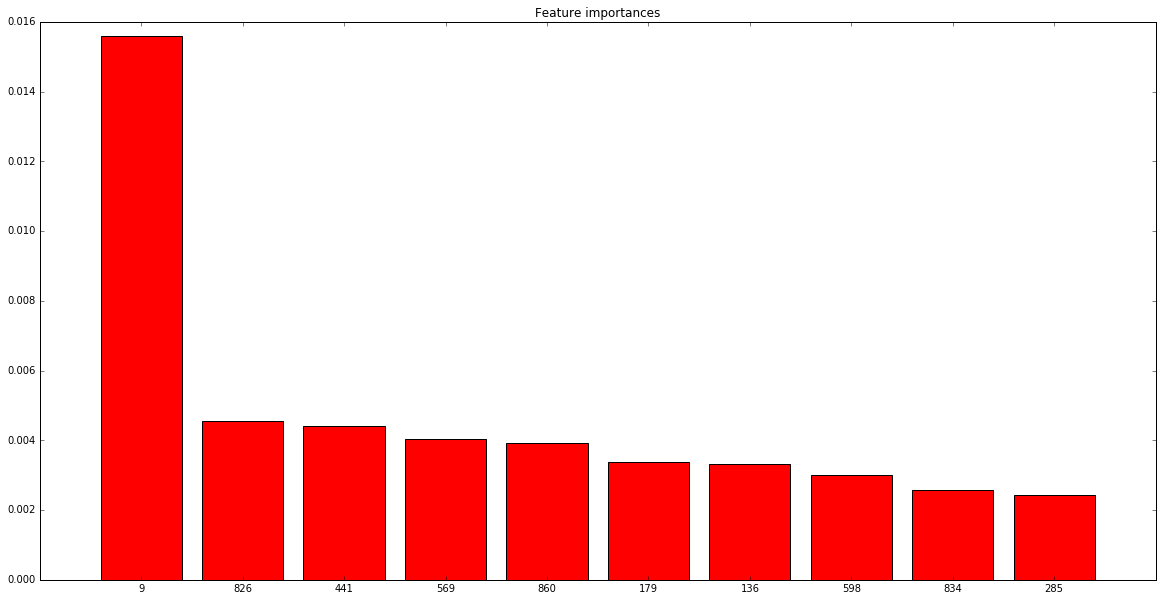

In [7]:
classifier.fit(X, y)
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1][:10]

print("Feature ranking (top 10):")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices],
       color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

Here I use sklearn method for feature preparation. This automatic feature engineering method lets us to reduce data dimension, that we'll use lately.

In [8]:
model = SelectFromModel(classifier, prefit=True)
X_new = model.transform(X)
X_new.shape

(100, 110)

Here we check the performance of selected classifier. According to data format and amount we have to use cross-validation. Appropriate metrics for this is ROC-AUC

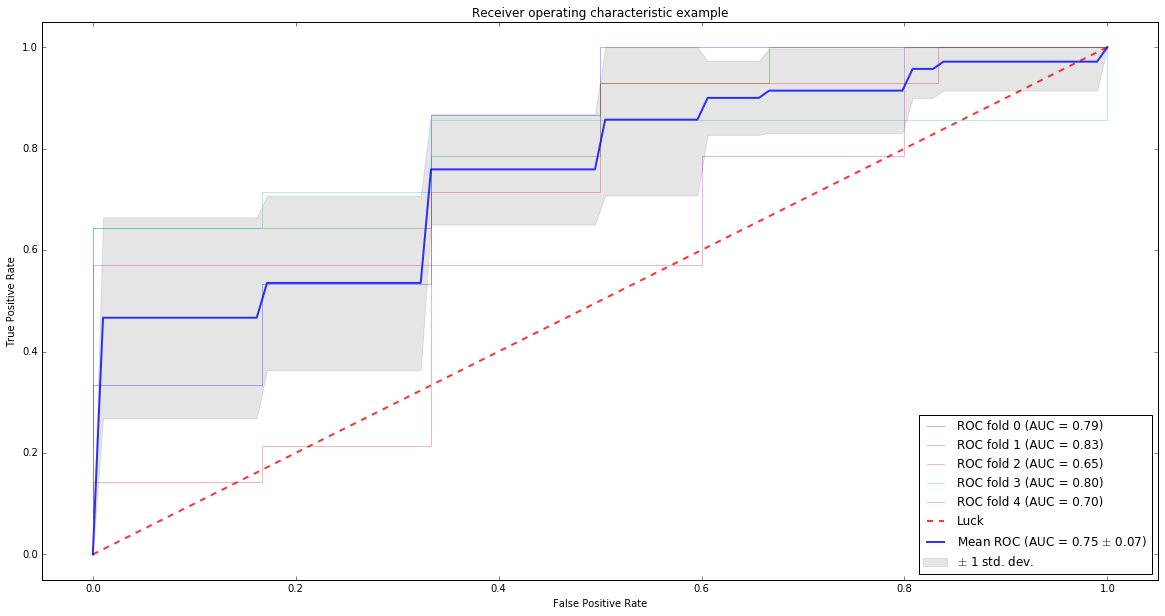

In [9]:
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

After feature engineering we can build an optimized classifier. With reduced data we may build a hyperparameter space and find the optimal values. GridSearch method is not the best solution I used, but it can be implemented faster than others

In [10]:
tuned_parameters = [
    {'learning_rate':[0.1, 0.01],
     'n_estimators':[100, 120, 150, 200, 300, 500],
     'max_depth':[2, 3, 5, 7]
    }]
score = 'roc_auc'

clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=5,
                       scoring=score)
clf.fit(X_new, y)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Score:")
print(clf.best_score_)

Best parameters set found on development set:
{'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 2}
Score:
0.909380952381


Here just a ROC-AUC for optimized classifier trained with "optimized" data.
Also we could use just 20 (put your number) best features that we found previously. Obviously it would spoil the accuracy, but that would let use another simplified models or sometimes describe decision of model in human-like way

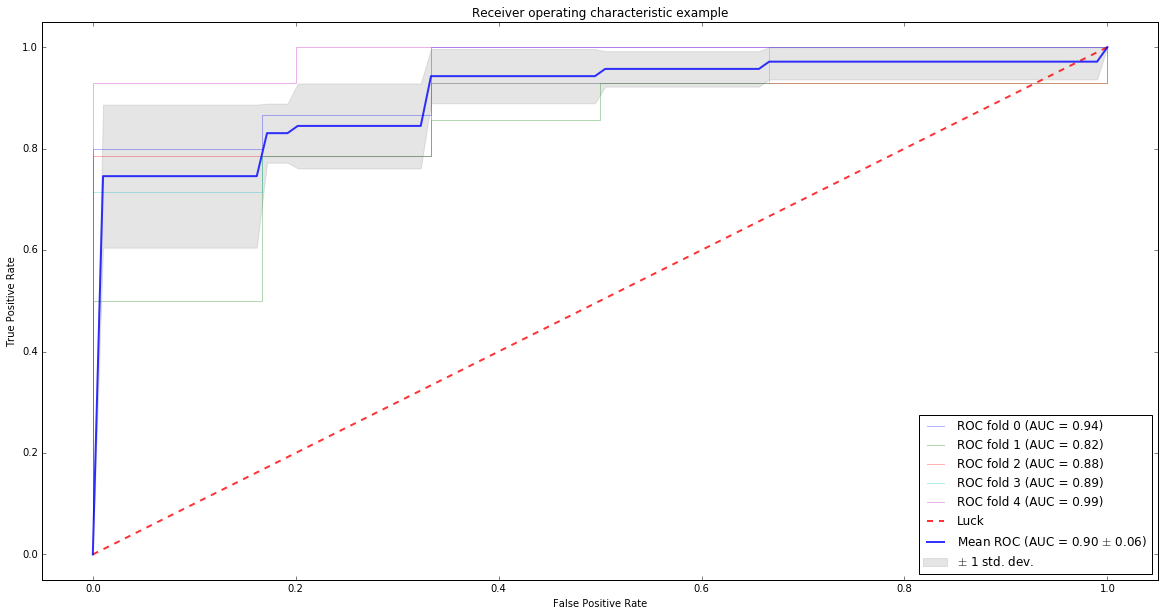

In [12]:
cv = StratifiedKFold(n_splits=5)
optimized_classifier = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=2)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_new, y):
    probas_ = optimized_classifier.fit(X_new[train], y[train]).predict_proba(X_new[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()